Mar 12 21:26:11 2024

## How to get a basic deep learning system: from CMU 10-714

从最基本的单元开始, 自底向上讲一个最简单的深度学习框架构成

### 计算图

一个复杂的神经网络, 其底层也无非是一些简单的数学运算, 当然, 也包括一些矩阵运算, 形态转换等等

一个很容易想到的点是需要用一个节点来表示这些运算过程中需要用到的数据, 因此我们可以将节点分为两类

1. 数据节点
2. 运算符节点

在python中可以这样表示

In [10]:
class Data:# 数据
	pass
class Op:# 运算符
	pass
class Node:
	op: Op
	data: Data
	input: list["Node"]

我们在节点中可以同时存储数据信息和运算符信息, 因此对于一个节点来讲, 我们可以有它的输入, 可以有需要进行的运算方法, 也就有了该运算的结果, 因此, 一个节点如果是运算符节点, 那么它也是一个数据节点

对运算符进行抽象

In [86]:
class Op:
	def compute(self, *args):
		return NotImplementedError
	def __call__(self, *args):
		return Node.make_from_op(self, args)
class Node:
	op: Op
	data: Data
	input: list["Node"]
	@staticmethod
	def make_from_op(op:Op, inputs:list["Node"]):
		node = Node.__new__(Node)
		node.op = op
		node.input = inputs
		node.data = op.compute(*[x.data for x in inputs])
		return node
	def __init__(self, data):
		self.data = data
		self.op = None
		self.input = []

这样我们就可以使用运算操作直接自动生成计算图了

In [45]:
class Add(Op):
	def compute(self, a: Data, b: Data):
		return a + b

X = Node(10)
b = Node(1)

y = Add()(X,b)

print("y :%s\nop:%s\ndata:%s\ninput:%s" % (y, y.op, y.data, y.input))

y :<__main__.Node object at 0x10b0bfac0>
op:<__main__.Add object at 0x10b0be650>
data:11
input:(<__main__.Node object at 0x106e880a0>, <__main__.Node object at 0x10b0bf5e0>)


当然, 你也可以做的更加复杂, 比如将操作设置一个单独的模块, 用ops.add之类的方法调用, 或者在Node中设置__add__之类的方法重载运算符, 本文不赘述这些内容, 具体见[CMU 10-714](https://dlsyscourse.org)

现在为了后面讲自动微分, 额外添加一个运算 元素乘

In [ ]:
class Mul(Op):
	def compute(self, a: Data, b: Data):
		return a * b

### 自动微分

对于 y = wx + b

```python
        p4     p5
       (W)    (b)
        |      |
(x) -> (*) -> (+) -> y
p1     p2     p3
```

有

$$
\begin{aligned}
y=p3 &=> \frac{\partial y}{\partial p3}=1\\
p3=p2+p5 &=> \frac{\partial y}{\partial p2}=\frac{\partial y}{\partial p3}\frac{\partial p3}{\partial p2}=1\\
&=>\frac{\partial y}{\partial p5}=\frac{\partial y}{\partial p3}\frac{\partial p3}{\partial p5}=1\\
p2=p4*p1&=>\frac{\partial y}{\partial p1}=\frac{\partial y}{\partial p2}\frac{\partial p2}{\partial p1}=p4=w\\
&=>\frac{\partial y}{\partial p4}=\frac{\partial y}{\partial p2}\frac{\partial p2}{\partial p4}=p1=x\\
\end{aligned}
$$

自动微分的过程就是反向去传播这些一小步的梯度的过程, 与bp不同的地方在于

1. 不需要手动计算, 因为任何一个运算符对应的导数是已知的
2. 在存在环时, 会使用扩展计算图, 将每一个梯度推到input中对应的节点上, 也就是如果一个节点直接的作为后面不止一个节点的input, 就需要全微分, 将梯度累和

现在对这种简单形式进行自动微分实现, 已知, 不管什么情况, 最后传回时第一个梯度是1

In [97]:
class Node:
	op: Op
	data: Data
	input: list["Node"]
	grad: Data #new
	@staticmethod
	def make_from_op(op:Op, inputs:list["Node"]):
		node = Node.__new__(Node)
		node.op = op
		node.input = inputs
		node.data = op.compute(*[x.data for x in inputs])
		return node
	def __init__(self, data):
		self.data = data
		self.op = None
		self.input = []
	def backward(self, out_grad = 1):
		compute_gradient(self, out_grad)
		
def compute_gradient():
	pass

也就是我们需要从最后一个节点调用backward开始, 将当前已经组合好的链式偏导乘上每一个运算符对应的导数, 得到一个新的链式偏导存在每个节点中的grad中, 这个grad就相当于y对当前节点的偏导, 具体形式即之前的公式

很显而易见的一个点是, 这个传播一定是从后往前不能跨过节点的, 因此我们需要对节点(计算图)进行拓扑排序, 其实就是dfs

In [101]:
def find_topo_sort(node_list: list[Node]) -> list[Node]:

    visited = set()
    topo_order = list()
    for node in node_list:
        if node not in visited:
            topo_sort_dfs(node, visited, topo_order)
    return topo_order

def topo_sort_dfs(node, visited, topo_order):
    for next in node.input:
        if next not in visited:
            topo_sort_dfs(next, visited, topo_order)
    
    if node not in visited:
        visited.add(node)
        topo_order.append(node)

接着我们需要在compute_gradient中每次从这个序列中拿一个Node进行grad计算

In [100]:
def compute_gradient(output_tensor, out_grad):

    node_to_output_grads_list: dict[Node, list[Node]] = {}
    # 正如之前所说, 存在环时, 每个节点可以会获得来自不同节点的梯度(全微分)
    node_to_output_grads_list[output_tensor] = [out_grad]
    
    reverse_topo_order = list(reversed(find_topo_sort([output_tensor])))
    # 序列
    
    for node in reverse_topo_order:
    #每次取一个值
        
        node.grad = sum(node_to_output_grads_list[node])
        #将梯度累加, 如果形如y=wx+b这种简单形式, dict中只有一个值
        
        if node.op == None:
            continue
        # 即数据节点, 像x,b之类的, 这些节点也可以看作叶子节点, 因为没有节点指向它, 也自然不用反向传播

        node_grad_ad = node.op.gradient(node.grad, node)
        # 需要计算当前节点应该传出的梯度, 这与当前节点运算符有关
        
        for i, k in enumerate(node.input):
        # 将结果沿着input传给对应的Node上
            
            if k not in node_to_output_grads_list:
                node_to_output_grads_list[k] = []
            node_to_output_grads_list[k].append(node_grad_ad[i])
            # 像 a=b*c 这种, 存在a对b和a对c的偏导, 要分别放给对应的位置
            # 但类似固定值 比如 a=b+1 实际上只存在对b的偏导, 它也只有一个input

对上述内容做一个补充, 对于加法, 之前输入事实上是假设输入是变量, 若输入是常量则可以直接存储常量值

In [ ]:
class AddScalar(Op):
	def __init__(self, a):
		self.scalar = a
	def compute(self, x):
		return x + self.scalar

def add_scalar(x, a):
	return Add(a)(x)

此时, input就只有一个, 另一个常量不用管, 不在计算图中, 也不需要参与计算

梯度计算具体是

In [103]:
class Add(Op):
	def compute(self, a: Data, b: Data):
		return a + b
	def gradient(self, out_grad, node):
		return out_grad, out_grad
		
	
class Mul(Op):
	def compute(self, a: Data, b: Data):
		return a * b
	def gradient(self, out_grad, node):
		l, r = node.input
		return out_grad * r.data, out_grad * l.data

对于加法, 导数为1, 对于乘法, 导数为另一个输入的值, 将其与后面传来的梯度相乘, 对应链式法则

至此, 一个自动微分已经完成, 更多的任务在于一些复杂的计算, 比如卷积, 它的导数是什么

### Module

有了自动微分, 我们还需要对计算图上这些单元进行更高级的表达, 将其进行封装, 就有了Module的概念



In [60]:
class Module:
    def __call__(self, *args):
        return self.forward(*args)

class Linear(Module):
    # 初始化为 y = x + 1
    def __init__(self):
        self.w = Node(1)
        self.b = Node(1)
    def forward(self, x):
        return Add()(Mul()(x, self.w), self.b)
        # return x * w + b
        # 按照我之前所说的方法对这些运算重载到Node中就可以使用上面这样而不是手动调用
    

这样我们就有了最基础的一个模型, 一个一元一次函数, 接下来也将围绕其展开

In [73]:
model = Linear()
x = Node(10)
y = model(x)
print("y :%s\nop:%s\ndata:%s\ninput:%s\n" % (y, y.op, y.data, y.input))
y = y.input[0]
print("y :%s\nop:%s\ndata:%s\ninput:%s\n" % (y, y.op, y.data, y.input))
y = y.input[0]
print("y :%s\nop:%s\ndata:%s\ninput:%s\n" % (y, y.op, y.data, y.input))

<__main__.Node object at 0x106f72cb0> <__main__.Node object at 0x10b106ad0>
y :<__main__.Node object at 0x10b107cd0>
op:<__main__.Add object at 0x10b1072b0>
data:11
input:(<__main__.Node object at 0x10b1073a0>, <__main__.Node object at 0x10b106440>)

y :<__main__.Node object at 0x10b1073a0>
op:<__main__.Mul object at 0x10b107550>
data:10
input:(<__main__.Node object at 0x10b107100>, <__main__.Node object at 0x10b106ad0>)

y :<__main__.Node object at 0x10b107100>
op:None
data:10
input:[]



上面三个结果对应y, wx, x, 因为取的都是input[0], 这与构造时传递参数的顺序有关, 见Linear中的forward构造顺序



### Parameters

有了Module, 我们需要在Module中记录参数, 这个参数既需要参与运算, 也需要被拿来更新, 因此, 我们需要对Parameters进行封装, 让它拥有不用的类别, 以方便被直接取出(Module中可能有很多值, 我们需要标记哪些值是需要更新的)

In [93]:
class Parameter(Node):
    """A special kind of Node that represents parameters."""


def _unpack_params(value: object) -> list[Node]:
    if isinstance(value, Parameter):
        return [value]
    elif isinstance(value, Module):
        return value.parameters()
    elif isinstance(value, dict):
        params = []
        for k, v in value.items():
            params += _unpack_params(v)
        return params
    elif isinstance(value, (list, tuple)):
        params = []
        for v in value:
            params += _unpack_params(v)
        return params
    else:
        return []

class Module:
    def parameters(self) -> list[Node]:
        return _unpack_params(self.__dict__)
    def __call__(self, *args):
        return self.forward(*args)
    
class Linear(Module):
    # 初始化为 y = x + 1
    def __init__(self):
        self.w = Parameter(1)
        self.b = Parameter(1)
        # 直接调用Node的构造函数, 等于Node(1), 但是可以被isinstance(Parameter)识别
    def forward(self, x):
        return Add()(Mul()(x, self.w), self.b)

至此, 我们有了每个节点的梯度, 有了模型的参数(参数也是节点), 接来下就是用梯度对参数进行更新

### Loss

在那之前, 先添加一个损失函数

In [52]:
class Sub(Op):
	def compute(self, a, b):
		return a - b
	def gradient(self, out_grad, node):
		return out_grad, - out_grad
class Loss(Module):
	def forward(self, x, y):
		return Mul()(Sub()(x, y), Sub()(x, y))
		# 平方损失

### Optimizer

我们需要将之前module中的参数取出, 交由优化器保管, 在优化器中我们会遍历每一个参数, 将其与梯度进行运算, 当然也可以包含一些正则化项

In [105]:
class Optimizer:
    def __init__(self, params):
        self.params = params

class SGD(Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.0, weight_decay=0.0):
        super().__init__(params)
        self.lr = lr
        # 学习率
        self.momentum = momentum
        # 带动量的sgd
        self.u = {}
        # 记录历史信息
        self.weight_decay = weight_decay
        # 正则化

    def step(self):
        for pa in self.params:
            u = self.momentum * self.u.get(id(pa), 0) \
                + (1 - self.momentum) * (pa.grad + self.weight_decay * pa.data) 
            pa.data -= self.lr * u
            self.u[id(pa)] = u


至此优化器就完成了, 有了模型, 有了优化器, 我们还需要数据集

### dataloader

通过一个简易的dataloader来介绍其作用和可以实现的功能

In [91]:
class Dataset:
    def __init__(self, points):
        self.data = points
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        return self.data[i]

class DataLoader:
    def __init__(self, dataset: Dataset):
        self.dataset = dataset

    def __iter__(self):
        self.idx = 0
        return self

    def __next__(self):
        if self.idx >= len(self.dataset):
            raise StopIteration
        
        out = self.dataset[self.idx]
        self.idx += 1
        
        return Node(out[0]), Node(out[1])
    

在dataset中存储最基本的数据, 样例中是一些平面上的点, out[0]是x值, out[1]是y值

然后通过dataloader将这些数据封装, 方便用for循环直接导出

In [64]:
dataloader = DataLoader(
				Dataset([[1,2],[2,4],[3,5.5],[4,7.6]])
			 )

for X, y in dataloader:
	print(X.data, y.data)

1 2
2 4
3 5.5
4 7.6


至此, 我们可以开始训练一个一元一次函数去拟合二维平面上的点

loss  2.1539265841539996
loss  0.6681107770048901
loss  0.6535141727479077
loss  0.6531575323083715
loss  0.6532708461987641


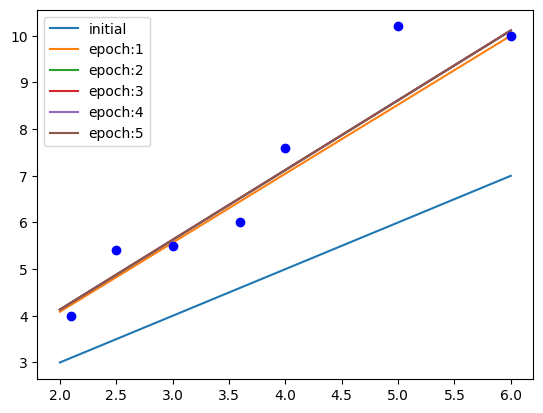

In [132]:
import matplotlib.pyplot as plt

dataloader = DataLoader(
				Dataset([[2.1,4],[3,5.5],[4,7.6],[5,10.2],[6,10],[2.5,5.4],[3.6,6]])
			 )
model = Linear()
lossm = Loss()
opt = SGD(model.parameters())

draw1 = model(Node(2))
draw2 = model(Node(6))
plt.plot([2, 6], [draw1.data, draw2.data], label="initial")

for epoch in range(5):
	lossavg = 0
	
	for X, y in dataloader:
		out = model(X)
		loss = lossm(out, y)
		loss.backward()
		opt.step()
		lossavg += loss.data
	
	draw1 = model(Node(2))
	draw2 = model(Node(6))
	plt.plot([2, 6], [draw1.data, draw2.data], label="epoch:%d"%(epoch+1))

	print("loss ", lossavg/len(dataloader.dataset))


for X, y in dataloader:
	plt.plot(X.data, y.data, 'bo')

plt.legend()
plt.show()


一个epoch就已经有很好的结果了, 一个令人吃惊的结论是, 如果你看代码, 你会发现 loss 值并没有参与运算, 而是隐含的在反向自动微分时被表达了

基础深度学习框架到此完毕, 接下来是一些具体模块的介绍

### 之前内容的补充

1. Dataloader

- 在dataloader中, 还可以设置很多功能, 比如用于批量计算的batch, 用于增强数据的transform(在取数据时对数据进行随机剪裁,缩放等处理), 以及是否打乱数据顺序等等

2. Module

- 在module中, 我们需要更多特性, 比如是训练模式还是推理模式(batchnorm), 是否需要冻结参数(require_grad)等等

3. 计算图

- 在之前的例子中, 计算图都是实时计算的, 可以增加比如懒计算之类的功能, 只在需要时才进行计算

### conv

卷积操作在实际计算中并不是按照其原理那样, 一次滑动算一次结果, 而是会把它展开, 将一个卷积操作转换为一个矩阵乘法操作

具体做法是假设现有两个矩阵

$$
\begin{aligned}
y &= 
{\left[ \begin{array}{cccc}
    X_{00} & X_{01} & X_{02}\\
    X_{10} & X_{11} & X_{12}\\
    X_{20} & X_{21} & X_{22}\\
    \end{array}
    \right ]}
*
{\left[ \begin{array}{cccc}
    k_{00} & k_{01} \\
    k_{10} & k_{11} \\
    \end{array}
    \right ]}\\
	\\
&=
{\left[ \begin{array}{cccc}
    R_0 & R_1 \\
    R_2 & R_3 \\
    \end{array} 
    \right ]}
\end{aligned}
$$

假设步长为1, padding为0, 则会有(H-k+1)*(W-k+1) = 4个卷积区域, 将每一个卷积区域转成一个行向量, 将卷积核转成一个列向量, 则原卷积操作转换为 (H,W)为数据二维尺寸, K为卷积核宽度

$$
\begin{aligned}
y &= reshape\left(
{\left[ \begin{array}{cccc}
    X_{00} & X_{01} & X_{10} & X_{11}\\
    X_{01} & X_{02} & X_{11} & X_{12}\\
    X_{10} & X_{11} & X_{20} & X_{21}\\
    X_{11} & X_{12} & X_{21} & X_{22}\\
    \end{array} 
    \right ]}
\times
{\left[ \begin{array}{cccc}
    k_{00}\\
    k_{01}\\
    k_{10}\\
    k_{11}\\
    \end{array} 
    \right ]}, shape=(H-k+1, W-k+1)\right)
	\\
&= reshape\left(
{\left[ \begin{array}{cccc}
    R_0 \\
	R_1 \\
    R_2 \\
	R_3 \\
    \end{array} 
    \right ]}, shape=(H-k+1, W-k+1)\right)
	\\
&=
{\left[ \begin{array}{cccc}
    R_0 & R_1 \\
    R_2 & R_3 \\
    \end{array} 
    \right ]}
\end{aligned}
$$


通过在空间上增加了冗余信息(重复数据), 但是通过却可以通过高效的矩阵乘法来计算

做几点补充:

1. 转换为行列向量

- 对原矩阵进行卷积区域拉伸是通过直接在原矩阵上进行步长改变实现的, 将原矩阵提升到高维空间, 改变每个方向上的步长得到新的矩阵, 在转回需要的形状

In [152]:
import numpy as np
A = np.array([[0,1,2],[3,4,5],[6,7,8]])
print(A)

H, W, K = 3,3,2
# K = kernel_size
Hs, Ws = A.strides[0], A.strides[1]

A = np.lib.stride_tricks.as_strided(A, shape=(H-K+1, W-K+1, K, K), strides=(Hs, Ws, Hs, Ws))

A = A.reshape((H-K+1)*(W-K+1), K*K)
A

[[0 1 2]
 [3 4 5]
 [6 7 8]]


array([[0, 1, 3, 4],
       [1, 2, 4, 5],
       [3, 4, 6, 7],
       [4, 5, 7, 8]])

2. 多通道

- 首先, 卷积核和数据通道数是一样的, 将对应区域的不同通道的数据也按上述展开, 对于数据, 列拼接, 对于卷积核, 行拼接

$$
\begin{aligned}
y &= 
{\left[ \begin{array}{cccc}
    X_{00} & X_{01} & X_{10} & X_{11} & \dots(4*chan_{in})\\
    X_{01} & X_{02} & X_{11} & X_{12} & \dots(4*chan_{in})\\
    X_{10} & X_{11} & X_{20} & X_{21} & \dots(4*chan_{in})\\
    X_{11} & X_{12} & X_{21} & X_{22} & \dots(4*chan_{in})\\
    \end{array} 
    \right ]}
\times
{\left[ \begin{array}{cccc}
    k_{00}\\
    k_{01}\\
    k_{10}\\
    k_{11}\\
	\vdots\\
	(4*chan_{in})\\
    \end{array} 
    \right ]}
	\\
&= 
{\left[ \begin{array}{cccc}
    R_0 \\
	R_1 \\
    R_2 \\
	R_3 \\
    \end{array} 
    \right ]}
	\\
\end{aligned}
$$

3. 多卷积核

- 卷积核数量等于输出通道数, 此时, 只增加第二个矩阵的列数就行

$$
\begin{aligned}
y &= 
{\left[ \begin{array}{cccc}
    X_{00} & X_{01} & X_{10} & X_{11} & \dots &(4*chan_{in})\\
    X_{01} & X_{02} & X_{11} & X_{12} & \dots &(4*chan_{in})\\
    X_{10} & X_{11} & X_{20} & X_{21} & \dots &(4*chan_{in})\\
    X_{11} & X_{12} & X_{21} & X_{22} & \dots &(4*chan_{in})\\
    \end{array} 
    \right ]}
\times
{\left[ \begin{array}{cccc}
    k_{00} & k2_{00} & \dots &(chan_{out})\\
    k_{01} & k2_{01} & \dots &(chan_{out})\\
    k_{10} & k2_{10} & \dots &(chan_{out})\\
    k_{11} & k2_{11} & \dots &(chan_{out})\\
	\vdots & \vdots  &\ddots & \vdots\\
	(4*chan_{in}) & \dots & \dots & (kernel\_size(4) * chan_{in}) * (chan_{out})\\
    \end{array} 
    \right ]}
	\\
&= 
{\left[ \begin{array}{cccc}
    R_0 & \dots &chan_{out}\\
	R_1 & \dots &chan_{out}\\
    R_2 & \dots &chan_{out}\\
	R_3 & \dots &chan_{out}\\
    \end{array} 
    \right ]}
	\\
\end{aligned}
$$

4. 批量卷积

假设batch为2, 对每个批次单独进行上述转换, 对第一个矩阵进行行拼接

$$
\begin{aligned}
y &= 
{\left[ \begin{array}{cccc}
    X_{00} & X_{01} & X_{10} & X_{11} & \dots &(4*chan_{in})\\
    X_{01} & X_{02} & X_{11} & X_{12} & \dots &(4*chan_{in})\\
    X_{10} & X_{11} & X_{20} & X_{21} & \dots &(4*chan_{in})\\
    X_{11} & X_{12} & X_{21} & X_{22} & \dots &(4*chan_{in})\\
	Y_{00} & Y_{01} & Y_{10} & Y_{11} & \dots &(4*chan_{in})\\
    Y_{01} & Y_{02} & Y_{11} & Y_{12} & \dots &(4*chan_{in})\\
    Y_{10} & Y_{11} & Y_{20} & Y_{21} & \dots &(4*chan_{in})\\
    Y_{11} & Y_{12} & Y_{21} & Y_{22} & \dots &(4*chan_{in})\\
    \end{array} 
    \right ]}
\times
{\left[ \begin{array}{cccc}
    k_{00} & k2_{00} & \dots &(chan_{out})\\
    k_{01} & k2_{01} & \dots &(chan_{out})\\
    k_{10} & k2_{10} & \dots &(chan_{out})\\
    k_{11} & k2_{11} & \dots &(chan_{out})\\
	\vdots & \vdots  &\ddots & \vdots\\
	(4*chan_{in}) & \dots & \dots & (kernel\_size(4) * chan_{in}) * (chan_{out})\\
    \end{array} 
    \right ]}
	\\
&= 
{\left[ \begin{array}{cccc}
    R_0 & \dots &chan_{out}\\
	R_1 & \dots &chan_{out}\\
    R_2 & \dots &chan_{out}\\
	R_3 & \dots &chan_{out}\\
	S_0 & \dots &chan_{out}\\
	S_1 & \dots &chan_{out}\\
    S_2 & \dots &chan_{out}\\
	S_3 & \dots &chan_{out}\\
    \end{array} 
    \right ]}
	\\
\end{aligned}
$$

### device

之前的计算数据类型是data:Data, 实际上在这里是用的int, 而对于复杂计算, 需要用到一个更复杂的类来表示一个数据, 换句话说, 我们需要自己实现一个Numpy

1. 我们需要在这个类上对矩阵进行特殊处理, 对于矩阵的表示可以像之前作卷积转换那样, 用shape和strides来在同一份数据上做不同的表示, 只在需要时才将两者分离(compact, 拷贝数据并按自己的shape和strides重新制作一个在内存上连续的数据)

2. 我们需要为这个数据提供最底层的运算, 即之前提到并实现的数据运算操作都集中到这个Data上来, 最终都应该由这个Data来负责计算

3. 在2的基础上, 我们就可以实现设备的功能了, 任何在这里会使用到的数据都不应该是什么原生类型, 而是封装好的Data, 我们可以设置device来选择在计算时调用什么样的函数, 比如使用cpu(c++)来进行一个运算操作还是gpu(cuda)来进行一个运算操作, 具体见CMU 10-714

In [ ]:
class Data:
    device: None
    def ewise_or_scalar(self, other, ewise_func, scalar_func):
        out = Data.make(self.shape, device=self.device)
        if isinstance(other, Data):
            ewise_func(self.compact(), other.compact(), out)
        else:
            scalar_func(self.compact(), other, out)
        return out

    def __add__(self, other):
        return self.ewise_or_scalar(
            other, self.device.ewise_add, self.device.scalar_add
        )

# C++
void ewise_add(const AlignedArray& a, const AlignedArray& b, AlignedArray* out) {
  for (size_t i = 0; i < a.size; i++) {
    out->ptr[i] = a.ptr[i] + b.ptr[i];
  }
}
void scalar_add(const AlignedArray& a, scalar_t val, AlignedArray* out) {
  for (size_t i = 0; i < a.size; i++) {
    out->ptr[i] = a.ptr[i] + val;
  }
}


### 高效矩阵乘法(CUDA)

假设对于一个长宽都为4的倍数的矩阵

$$
y = 
{\left[ \begin{array}{cccc}
    X_{00} & X_{01} & X_{02} & X_{03} & X_{04} & X_{05} & X_{06} & X_{07} \\
    X_{10} & X_{11} & X_{12} & X_{13} & X_{14} & X_{15} & X_{16} & X_{17} \\
    X_{20} & X_{21} & X_{22} & X_{23} & X_{24} & X_{25} & X_{26} & X_{27} \\
    X_{30} & X_{31} & X_{32} & X_{33} & X_{34} & X_{35} & X_{36} & X_{37} \\
    X_{40} & X_{41} & X_{42} & X_{43} & X_{44} & X_{45} & X_{46} & X_{47} \\
    X_{50} & X_{51} & X_{52} & X_{53} & X_{54} & X_{55} & X_{56} & X_{57} \\
    X_{60} & X_{61} & X_{62} & X_{63} & X_{64} & X_{65} & X_{66} & X_{67} \\
    X_{70} & X_{71} & X_{72} & X_{73} & X_{74} & X_{75} & X_{76} & X_{77} \\
    \end{array} 
    \right ]}
\times
{\left[ \begin{array}{cccc}
    Y_{00} & Y_{01} & Y_{02} & Y_{03} & Y_{04} & Y_{05} & Y_{06} & Y_{07} \\
    Y_{10} & Y_{11} & Y_{12} & Y_{13} & Y_{14} & Y_{15} & Y_{16} & Y_{17} \\
    Y_{20} & Y_{21} & Y_{22} & Y_{23} & Y_{24} & Y_{25} & Y_{26} & Y_{27} \\
    Y_{30} & Y_{31} & Y_{32} & Y_{33} & Y_{34} & Y_{35} & Y_{36} & Y_{37} \\
    Y_{40} & Y_{41} & Y_{42} & Y_{43} & Y_{44} & Y_{45} & Y_{46} & Y_{47} \\
    Y_{50} & Y_{51} & Y_{52} & Y_{53} & Y_{54} & Y_{55} & Y_{56} & Y_{57} \\
    Y_{60} & Y_{61} & Y_{62} & Y_{63} & Y_{64} & Y_{65} & Y_{66} & Y_{67} \\
    Y_{70} & Y_{71} & Y_{72} & Y_{73} & Y_{74} & Y_{75} & Y_{76} & Y_{77} \\
    \end{array} 
    \right ]}
$$

我们让每一个线程只处理其中一块区域, 将tile设为4, 4*32刚好时缓存行的大小

$$
y_{thread} = 
{\left[ \begin{array}{cccc}
    X_{i,0} & X_{i,1} & X_{i,2} & X_{i,3} & X_{i,4} & X_{i,5} & X_{i,6} & X_{i,7} \\
    X_{i+1,0} & X_{i+1,1} & X_{i+1,2} & X_{i+1,3} & X_{i+1,4} & X_{i+1,5} & X_{i+1,6} & X_{i+1,7} \\
    X_{i+2,0} & X_{i+2,1} & X_{i+2,2} & X_{i+2,3} & X_{i+2,4} & X_{i+2,5} & X_{i+2,6} & X_{i+2,7} \\
    X_{i+3,0} & X_{i+3,1} & X_{i+3,2} & X_{i+3,3} & X_{i+3,4} & X_{i+3,5} & X_{i+3,6} & X_{i+3,7} \\
    \end{array} 
    \right ]}
\times
{\left[ \begin{array}{cccc}
    Y_{0,j} & Y_{0,j+1} & Y_{0,j+2} & Y_{0,j+3}  \\
    Y_{1,j} & Y_{1,j+1} & Y_{1,j+2} & Y_{1,j+3}  \\
    Y_{2,j} & Y_{2,j+1} & Y_{2,j+2} & Y_{2,j+3} \\
    Y_{3,j} & Y_{3,j+1} & Y_{3,j+2} & Y_{3,j+3}  \\
    Y_{4,j} & Y_{4,j+1} & Y_{4,j+2} & Y_{4,j+3} \\
    Y_{5,j} & Y_{5,j+1} & Y_{5,j+2} & Y_{5,j+3} \\
    Y_{6,j} & Y_{6,j+1} & Y_{6,j+2} & Y_{6,j+3} \\
    Y_{7,j} & Y_{7,j+1} & Y_{7,j+2} & Y_{7,j+3}  \\
    \end{array} 
    \right ]}
$$

In [ ]:
struct __device_builtin__ __builtin_align__(16) float4{
	float data_[4];

	CUDAF2 float operator[](size_t idx){
		return data_[idx];
	}

	CUDAF2 float4 operator+(const float4 &a){
		return float4{data_[0]+a.data_[0], data_[1]+a.data_[1],
					  data_[2]+a.data_[2], data_[3]+a.data_[3]};
	}

	CUDAF2 float4 operator*(float f){
		return float4{data_[0]*f, data_[1]*f, data_[2]*f, data_[3]*f};
	}
};

具体计算过程, 此时每个线程计算的结果是4x4的矩阵

In [ ]:
# 伪代码
float4 C[4];

for(size_t i=0;i<N;i++){
	# 左边一列对应右边一行
	
	float4 tmp = B(i, 0);
	# 一次从右边拿一行, 放入float4
	
	for(int j=0;j<TILE;j++){
	# 遍历左边一列四个元素
	C[j] = C[j] + tmp * A(j, i);
	# 累加右边一行与左边一个元素的乘积
	}
}

for(int i=0;i<TILE;i++){
	OUT(i,0) = C[i];
}

接下来可以通过加大计算量的方式, 比如一次取左边8行, 右边8列, 每边分为两个原先的4xN, 此时每个线程计算的结果是4个4x4的矩阵

具体计算过程:

In [ ]:
__shared__ memA
__shared__ memB
# 设置两块共享内存(左右)

for(size i=0; i< N/TILEK; i++){
	#将原先循环拆为两步, 一次让共享内存读入左边8*TILEK和右边TILEK*8的数据
	memA = mat[thread_idx]
	__syncthreads();
	memB = mat[thread_idx]
	__syncthreads();

	for(size j=0; j<TILEK; j++){
		...
		# 此时计算就不用去全局内存中取数据了
	}
}